## TP 1

### Ejercicio 3 _ECG_

**Autor:** Baldezzari Lucas

_Nota_: En general intentaré escribir los comentarios y variables en el código en _inglés_. Esto para evitar problemas de incompatibilidad para declarar variables, y de paso me sirve para practicar un poco escribir en inglés.

##### Importo algunos paquetes y funciones

In [1]:
import os
import numpy as np

from downloadECG import loadParams
from utils import pasaBanda, notch, plotECG, peakDetection, plotSeveralECG, splitECG
from Ejers1y2_TP1_AADoc import findingClusters

Cargo mis datos

In [2]:
#Load data
initialFolder = os.getcwd()
path = os.path.join(initialFolder,"mitdata")
os.chdir(path)

ecg = np.fromfile('100.dat', dtype = "byte")    
os.chdir(initialFolder) #vuelvo al directorio de inicio

params = loadParams("atributosECG-TP1.txt") #

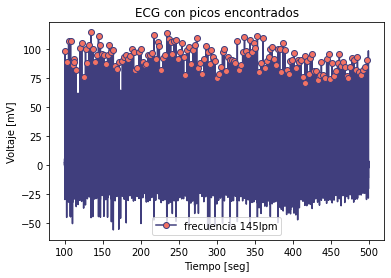

In [3]:
#Starting point
fm = 360.

#filtering the signal
filteredECG = notch(ecg, removeFrec = 50., fm = fm)
filteredECG = pasaBanda(filteredECG, lfrec = 2., hfrec = 45., order = 4, fm = fm)

#select a window
window = 1. #seg

#select time for cut the ECG signal
iniTime = 100. #secs
finalTime = 500. #secs

shortECG = filteredECG[int(iniTime*fm):int(finalTime*fm)]

# plot a piece of ECG
# plotECG(shortECG, fm = 360., iniTime = iniTime, finalTime = finalTime,
#         title = "ECG", savePlots = False, folder = "figs")

std = np.std(filteredECG)
threshold = 7*std #selecciono un umbral de 7 veces el std de la señal (¿por qué?, no hay por que :D )
#La selección del umbral fue realizada arbitrariamente.

peaks, indexes, avg = peakDetection(shortECG, window = 1.0, threshold = threshold,
                               fm = fm, startingIndex = int(iniTime*fm))   

#Plot the EEG with peak markers
plotECG(shortECG, fm = 360., iniTime = iniTime, finalTime = finalTime,
        markers = indexes, label = f"frecuencia {int(avg)}lpm",
        title = "ECG con picos encontrados", savePlots = True, folder = "figs") 

#### Implementación

La implementación de la detección de picos se encuentra dentro del archivo _utils.py_. La misma es,

```python
def peakDetection(ecg, window, threshold, fm = 360., startingIndex = 0):
    
    ecg = ecg - np.mean(ecg)
    peaks = []
    indexesPeak = []
    initialIndex = 0
    finalIndex = int(window*fm)
    maxIndex = ecg.shape[0]
    
    while True:        
        if finalIndex < maxIndex:            
            # valuePeak.append([value for value in shortECG if value >= threshold])
            maxValue = max(ecg[initialIndex:finalIndex])
            if maxValue >= threshold:
                peaks.append(max(ecg[initialIndex:finalIndex]))    
                indexesPeak.append(np.argmax(ecg[initialIndex:finalIndex])+initialIndex)
                
            initialIndex += int(window*fm)
            finalIndex += int(window*fm)
            
        else:
            peaks = np.array(peaks)
            indexesPeak = np.array(indexesPeak)# + startingIndex
            avg = 0
            for i in range(len(indexesPeak)-1):
                avg += indexesPeak[i+1] - indexesPeak[i]
            avgFreqRate = avg/(indexesPeak.shape[0]-1)/fm*60
            break
        
    return peaks, indexesPeak, avgFreqRate
```

#### Comentarios

Esta claro que al código le falta optimización. En algunos casos se da que se detectan dos picos R en uno solo. Además hay pequeñas cosas a mejorar, por ejemplo, en ningún momento se chequea si la variable _startingIndex_ no supera la variable _maxIndex = ecg.shape[0]_, pero esto es facil de solucionar. Existen otras pequeñeces que se podrían mejorar para hacer a este simple algoritmo algo más robusto.

### Encontrando patrones en el ECG

Se utiliza el método _findingClusters()_ implementado en los ejercicios 1 y 2 para encontrar grupos representativos dentro del ECG.

In [4]:
#Split the ECG data
splitWindow = 1 #secs
 
# plotECG(splittedecg[5][:], fm = 360., iniTime = 0, finalTime = 0,
#         title = "Splitted ECG", savePlots = False, folder = "figs")

splittedecg = splitECG(shortECG, peakIndexes = indexes, splitWindow = splitWindow, fm = fm)
#ecg, splitWindow, peakIndexes, fm = 360.

kClusters = 4
centersECG, labels = findingClusters(splittedecg, kClusters = kClusters, centers = None)

##### Gráficas

Podemos graficar los datos obtenidos.

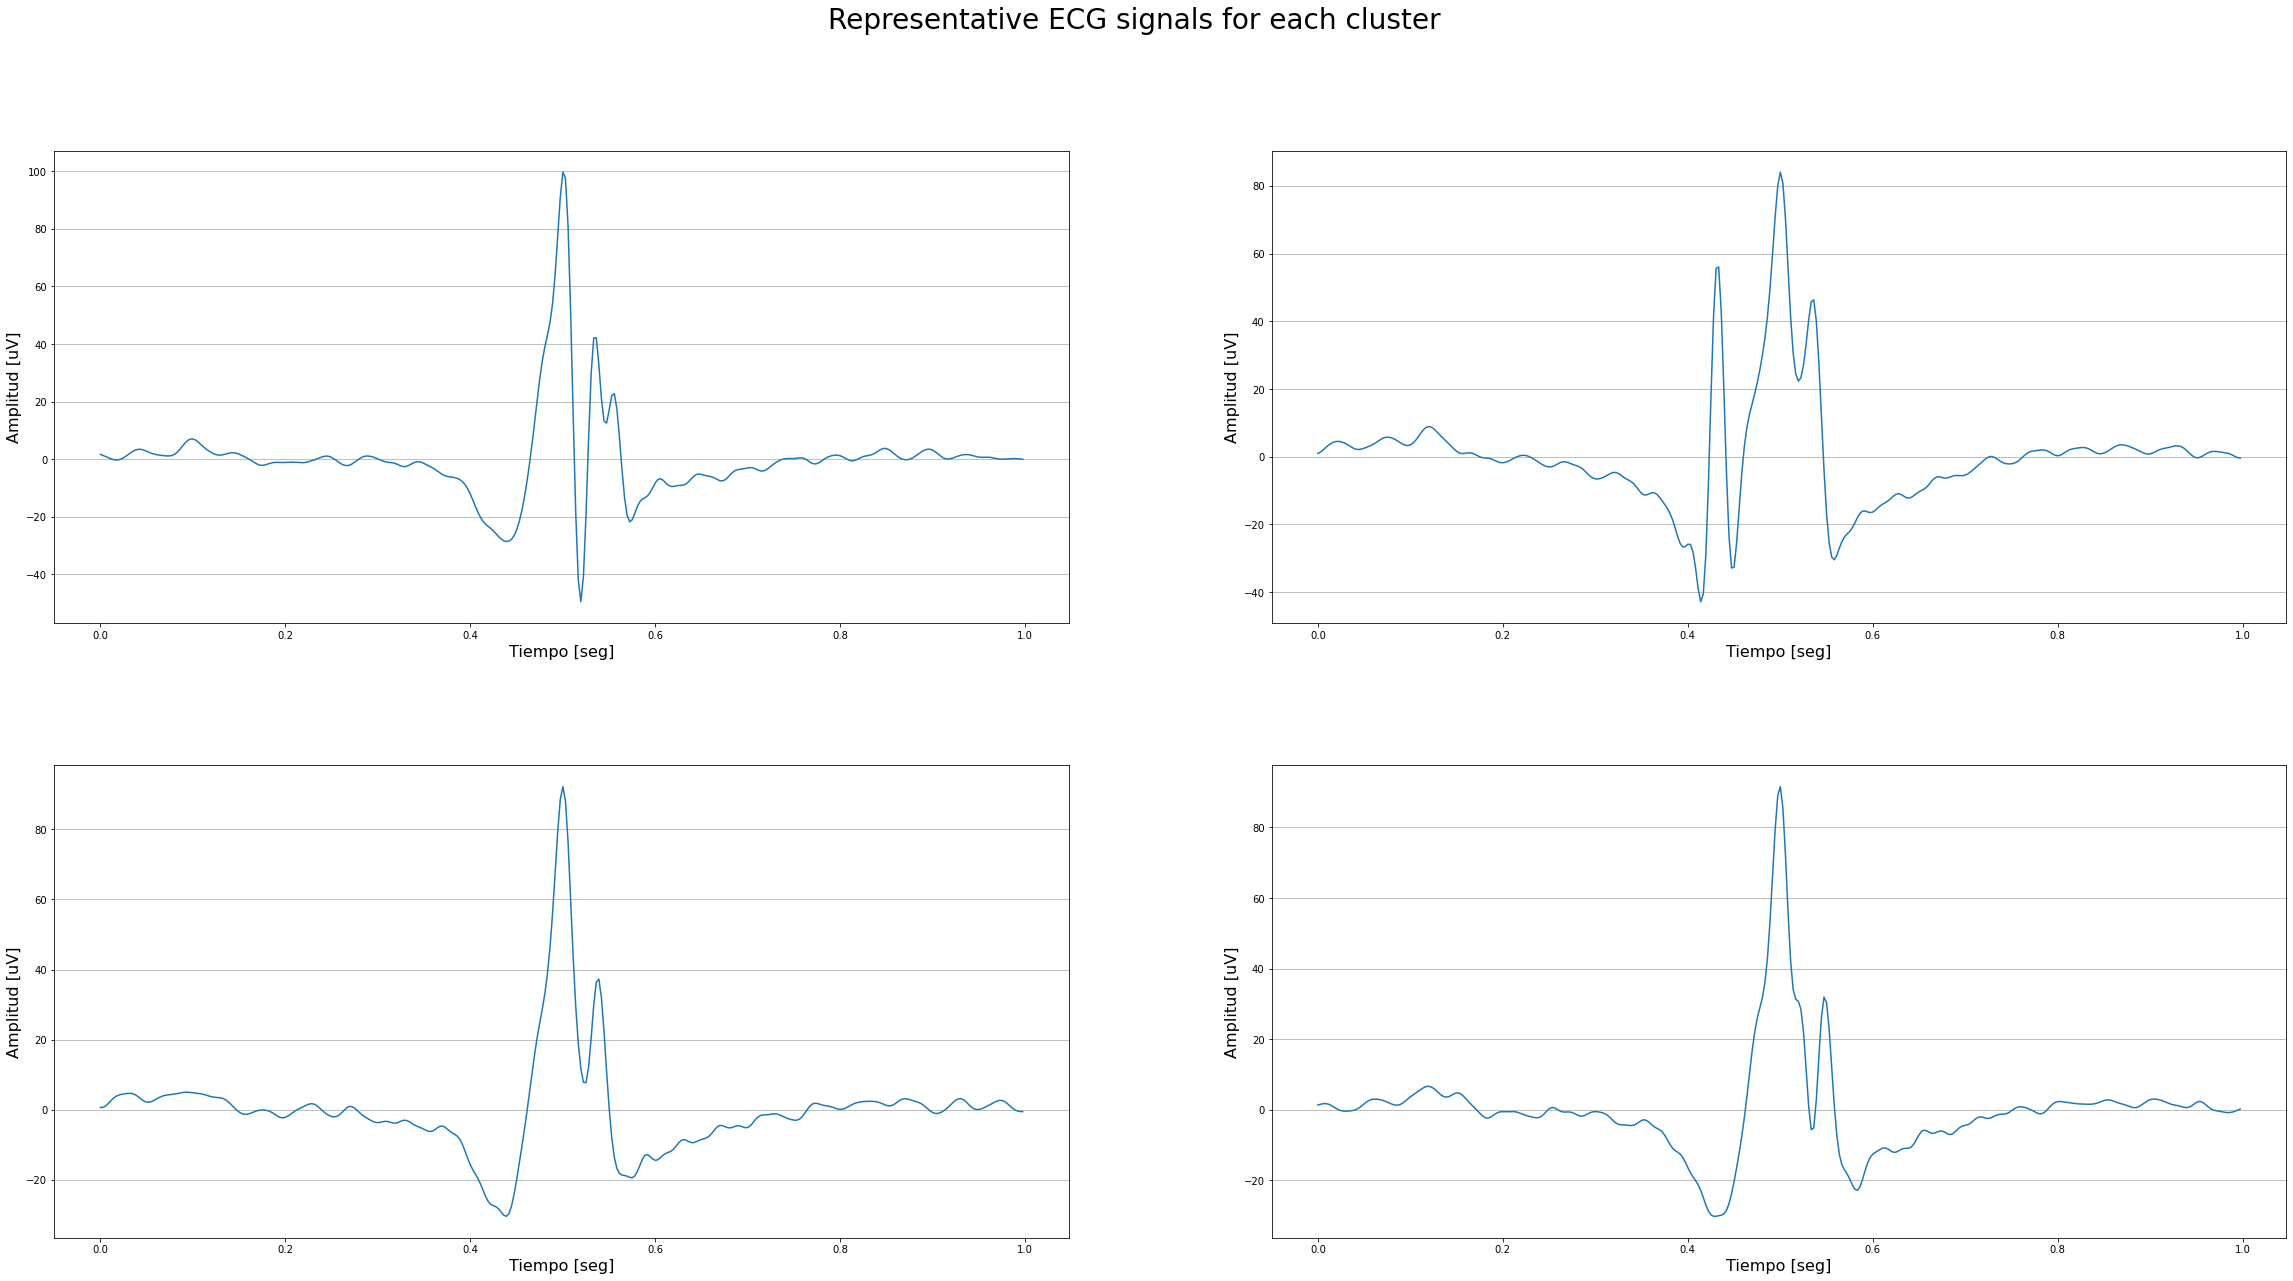

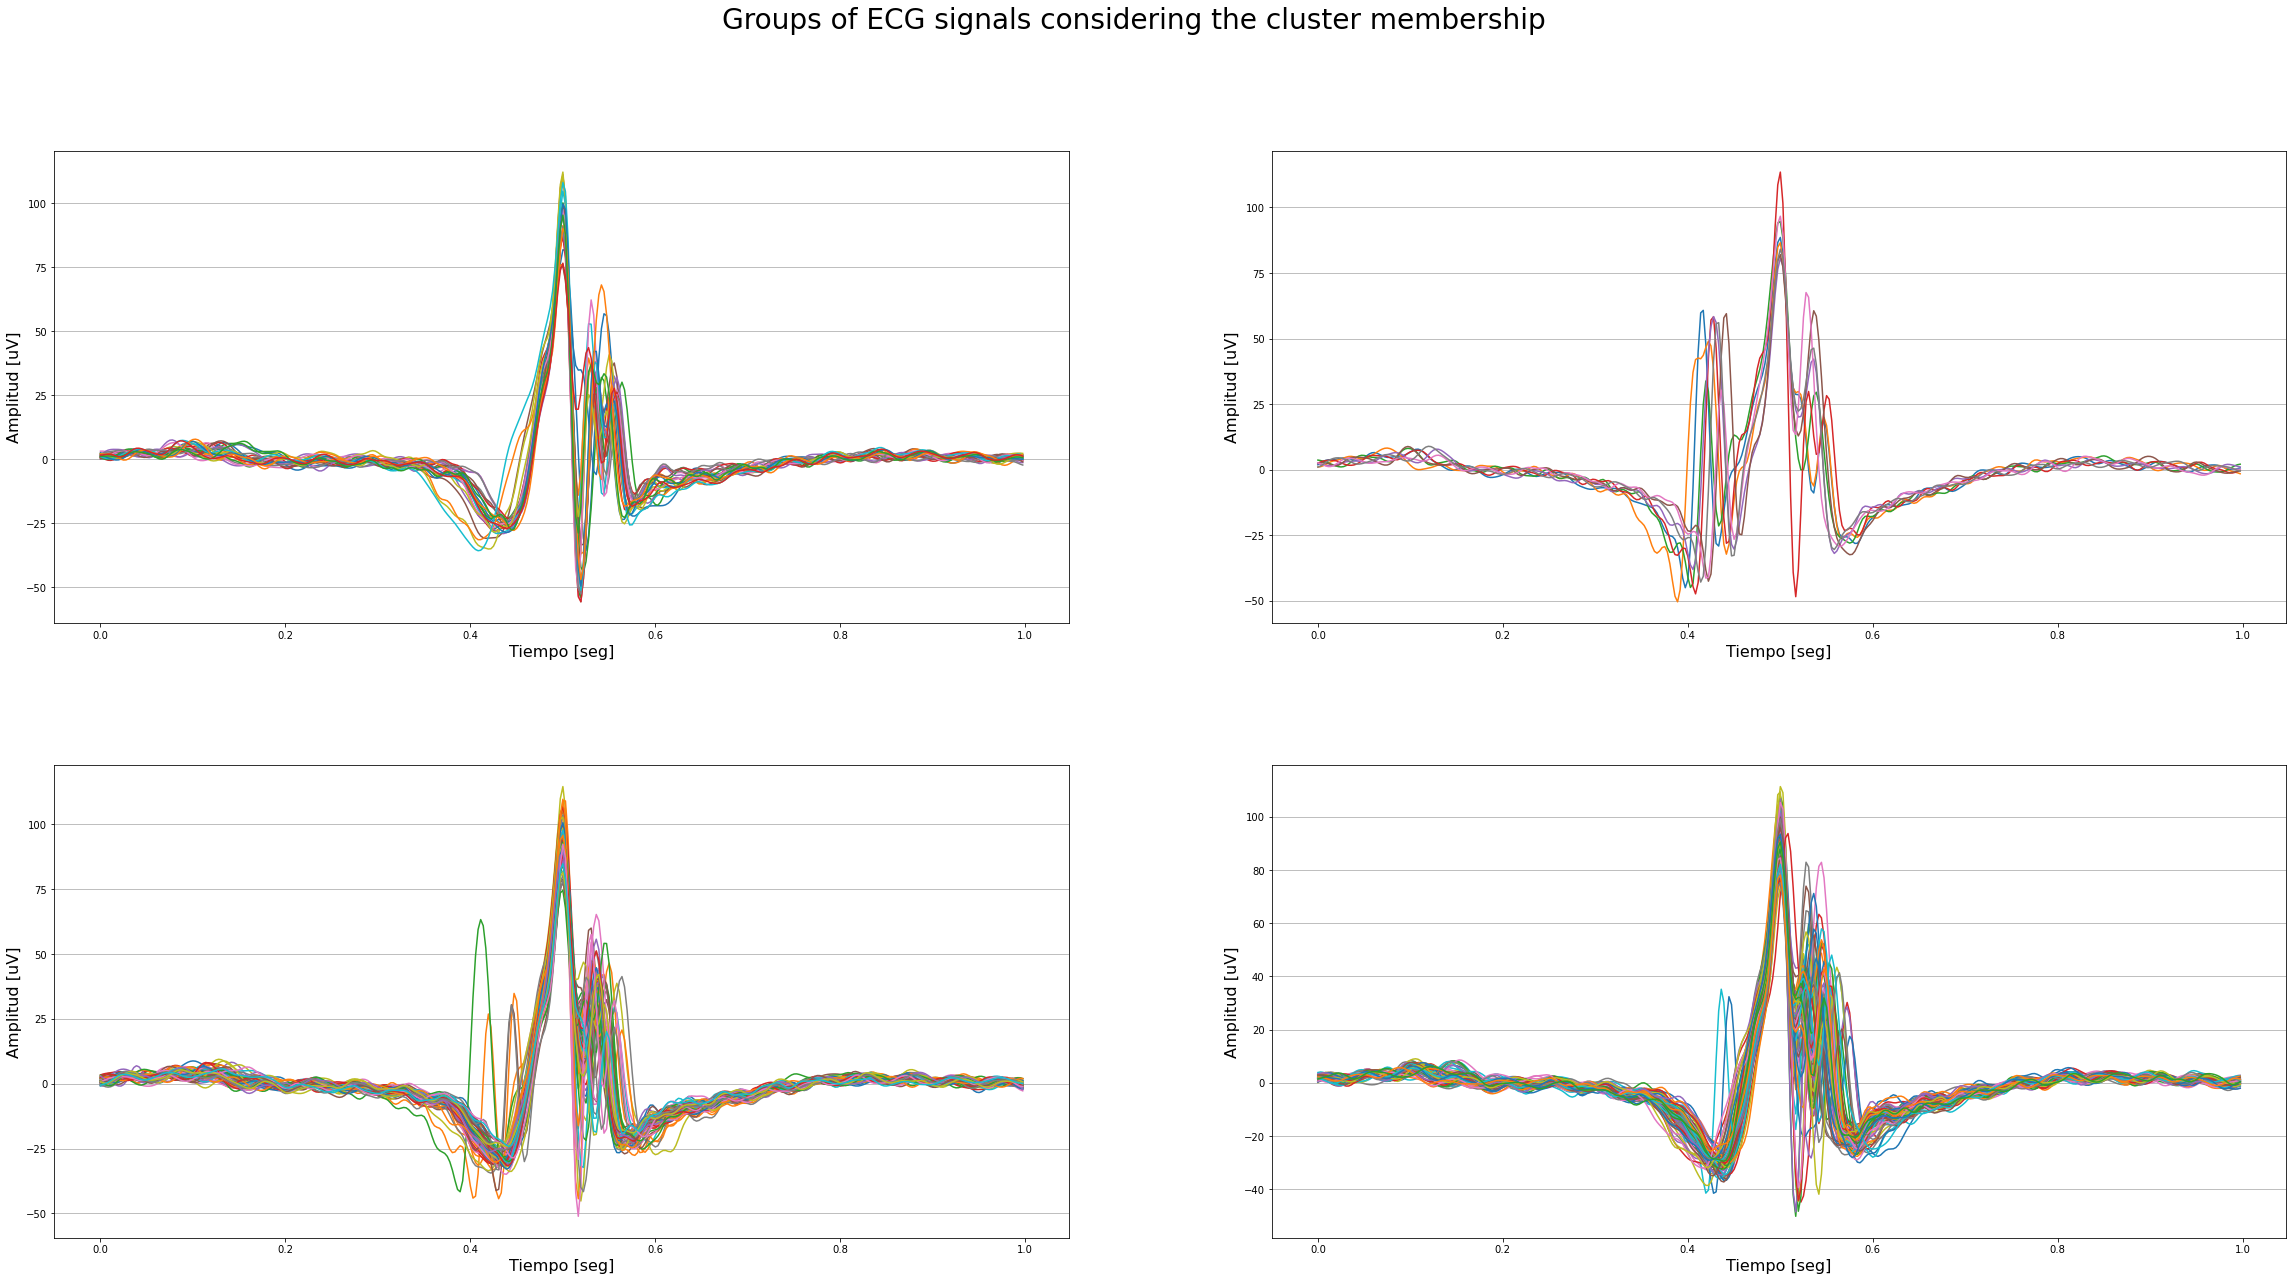

In [5]:
rows = int(np.ceil(kClusters/2))
# columns = int(np.ceil(len(np.unique(labels))//2))
if kClusters > 4 and kClusters % rows:
    columns = kClusters//rows+1
else:
    columns = kClusters//rows
    
plotSeveralECG(centersECG, labels = np.unique(labels),
                fm = 360., rows = rows, columns = columns,
                    iniTime = 0., finalTime = 0.,markers = [],
                    title = "Representative ECG signals for each cluster", savePlots = True,
                    folder = "figs")

plotSeveralECG(splittedecg, labels = labels,
                fm = 360., rows = rows, columns = columns,
                    iniTime = 0., finalTime = 0.,markers = [],
                    title = "Groups of ECG signals considering the cluster membership",
                    savePlots = True,
                    folder = "figs")